# Core concepts in statistics

Szymon Talaga | 15 March 2020

<hr>

In this notebook we will learn how to work in `R` with some the basic statistical concepts such as probability distributions, quantiles, confidence intervals and hypothesis test. A basic familiarity with `R` is assumed. Refer to the auxiliary notebooks with an introduction to `R` if needed.

## Tidyverse

In this class we will usually prefer so-called _Tidyverse_ packages and tools over tha base `R`. The reason is that code written with the _Tidyverse_ packages
is almost always easier to read and understand. Moreover, some of the main ideas used in these packages are relatively similar to how packages in the `Python`
ecosystem, such as _Numpy_ or _Pandas_, are designed.

In general we will use mostly two _Tidyverse_ packages: `dplyr` and `ggplot2`. The former will be used for processing data frames
(rectangular datasets with observations in rows and variables in columns) and the latter for data visualization.

You can read more about the _Tidyverse_ ecosystem [here](https://www.tidyverse.org/).

In [22]:
# Packages that we will need
library(tidyverse)    # read in core tidyverse packages at once
library(BSDA)         # some helper functions for working with z tests
library(latex2exp)    # for easy math on plots

# Set default theme for ggplot2
theme_set(theme_bw())

## Pipe operator `%>%` and stream processing

We will often use a special kind of symbol `%>%`. It is called the pipe operator and it is used to pass value from the left side as the first argument
to the function on the right side. For instance, the two expressions below are equivalent.

In [3]:
x <- 1:10

## Without the pipe
mean(x)

## With the pipe
x %>% mean

[1] 5.5

[1] 5.5

In [4]:
## Can also do this
x %>% mean(na.rm = TRUE)
## to pass additional arguments to methods down the chain.

## The above is equivalent to:
mean(x, na.rm = TRUE)

[1] 5.5

[1] 5.5

The pipe operator is implemented in `magrittr` package. You can find a short introduction [here](https://magrittr.tidyverse.org/).

## `ggplot2`

For plotting we will usually use the `ggplot2` package. You can read more about it [here](https://ggplot2.tidyverse.org/).

## Probability distributions

We start by learning about probability distributions. We discussed this concept quite extensively on the theoretical level in the textbook and here we will
try to build more of a practical, hands-on understanding. The focus will be on the difference between probability mass and probability density functions
(discrete and continuous random variables) as well as cumulative distribution and quantile functions. Of course we will also talk quite a bit about normal
distributions.

In general in R, there is a well defined set of functions for working with probability distributions. In general for any probability distribution
there are the following function:

* `d<name>`: compute PMF/PDF values.
* `p<name>`: compute CDF values.
* `q<name>`: compute quantile values.
* `r<name>`: generate pseudo-random numbers.

Where `<name>` stands for an abbreviated name of a distribution. For instance, for normal distributions we have:

* `dnorm`: compute normal PDF valeus (probability density).
* `pnorm`: compute normal CDF.
* `qnorm`: compute normal quantiles.
* `rname`: generate psudo-random normal numbers.

**NOTE.** Remember that you can aways access extensive documentation of almost any `R` function using
the `?` operator. For instance, if you want to learn how to sample from normal distribution you can just
write `?rnorm` in the console.

### Probability mass function (PMF) [discrete variables]

Probability mass functions are used to define probability distributions over outcomes of discrete random variables. They are called mass functions because
they assign probabilities to particular discrete points as if they were abstract points with point masses (a sort of abstraction often used in physics).
This is their characteristic feature because as we will soon see for continuous variables probabilities can be defined only for proper ranges of points
and never for individual points.

Now we will work a little with the PMF of Poisson distribution. So  if $X$ is a random variables with Poisson distribution with parameter $\lambda$ then its
PMF denoted by $p_X(x)$ is:

$$
p_X(x) = \frac{\lambda^x e^{-\lambda}}{x!}
$$

So the above function defines the probability that a realization of a random variable $X$ with Poisson distribution with a parameter $\lambda$ will be
exactly $x$.

Poisson distribution is defined for all non-negative integers ($\mathbb{N}_0$). Its important feature is that $\mathbb{E}[X] = \lambda$ and
$\text{Var}[X] = \lambda$. Poisson distributions are important because they often arise naturally in the context of discrete count variables, that is
random variables measuring numbers of occurrences of some objects (negative numbers are not possible).

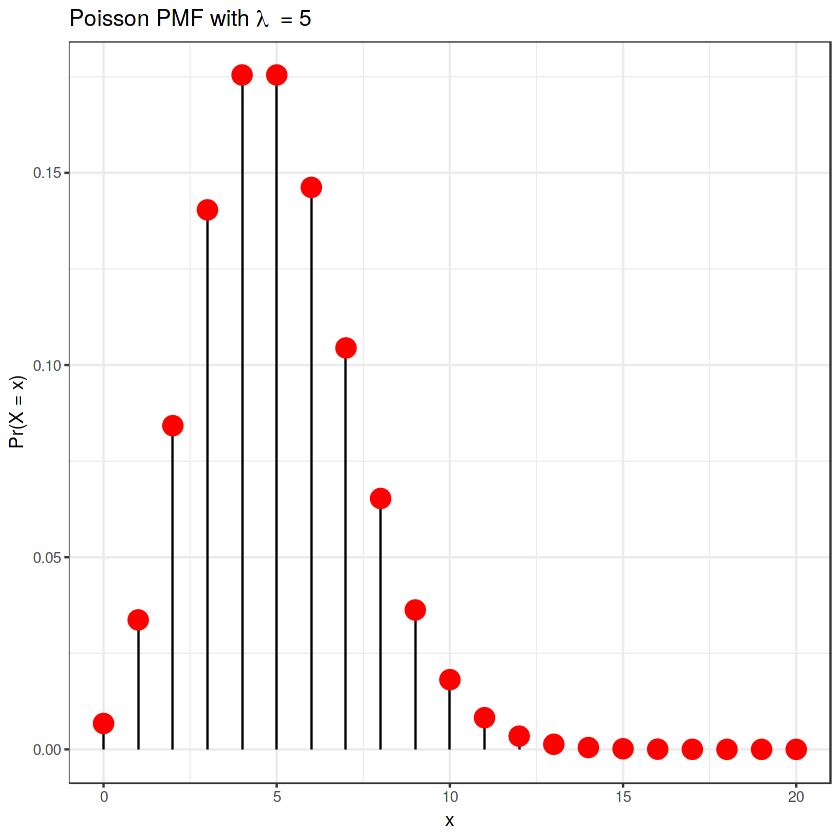

In [63]:
## Here we draw PMF of a Poisson distribution with lambda = 5
## We will limit X values to the range 0:20
lambda <- 5
x <- 0:20

data <- data.frame(
    x = x,
    p = dpois(x, lambda = lambda)
)

data %>%
    ggplot(aes(x = x, y = p)) +
    geom_segment(aes(x = x, y = 0, xend = x, yend = p)) +
    geom_point(color = "red", size = 5) +
    xlab("x") +
    ylab("Pr(X = x)") +
    ggtitle(TeX("Poisson PMF with $\\lambda$ = 5"))

Note that the above representation of the PMF is proper because it emphasizes that $\Omega_X$ contains only integer values.
Similarily, we can represent the CDF of a Poisson variable.

In [64]:
## We can use the previous `data` object
head(data)

,x,p
,<int>,<dbl>
1,0,0.006737947
2,1,0.033689735
3,2,0.084224337
4,3,0.140373896
5,4,0.175467370
6,5,0.175467370


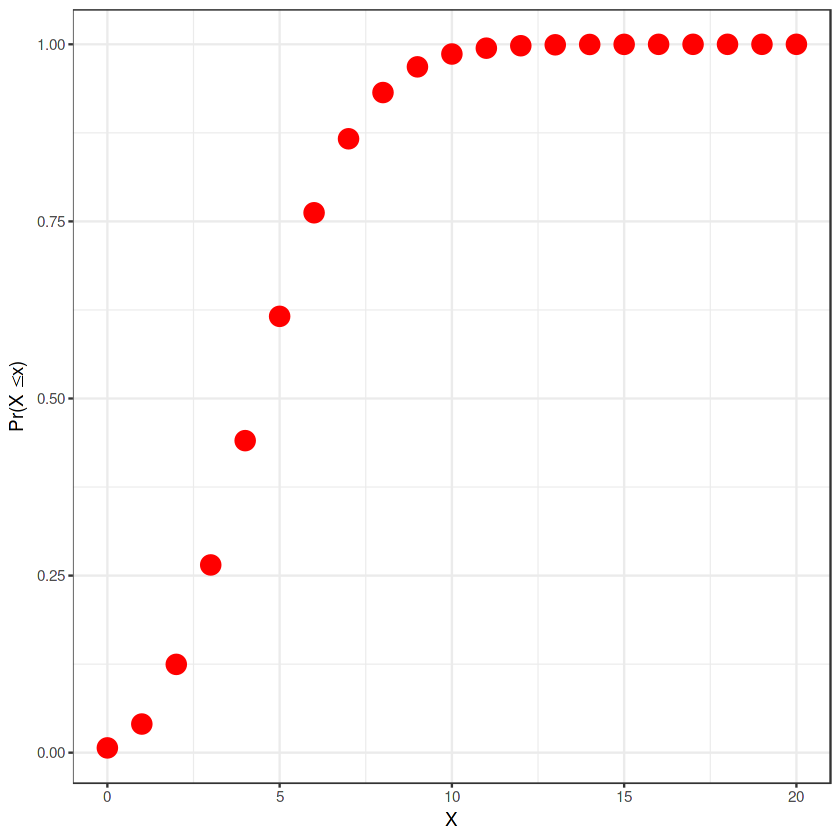

In [65]:
## And just add a new column with CDF values based on `x`
data$cdf <- ppois(data$x, lambda = lambda)

## And now we can visualize
data %>%
    ggplot(aes(x = x, y = cdf)) +
    geom_point(color = "red", size = 5) +
    xlab("X") +
    ylab(TeX("Pr($X \\leq x$)"))

Note that again, we do not join the points with lines to emphasize the fact that this a discrete distribution. The CDF clearly show that almost all values
samples from the distribution will be not greater than $10$.

So the crucial thing one has to remember about probability mass functions and discrete variables is that we have the following equality:

$$
\text{CDF}_X(x) = \text{Pr}(X \leq x) = \sum_{x_0 \leq k \leq x}p_X(k)
$$

where $X$ is a discrete random variable with the probability mass function $p_X(x)$ and $x_0$ is the minimum value in $\Omega_X$.

So in other words we can always recreate CDF by just adding up values of PMF. As we will see this is not as easy in the case of probability density functions.

## Probability density function (PDF) [continuous]

Probability density functions define probability distributions over outcomes of continuous random variables such as normally distributed variables.based 
Now we will try to understand them based on the normal PDF.

From now on we will denote PMFs by $p_X(x)$ and PDFs by $f_X(x)$ to avoid confusion.

PDF of a normal random variables with mean $\mu$ and variance $\sigma^2$ is defined as:

$$
f_X(x) \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{n}(\frac{x - \mu}{\sigma})^2}
$$

In the textbook we always use the parametrization in terms of mean $\mu$ and variance $\sigma^2$.
However, sometime standard deviation $\sigma$ is used instead of variance $\sigma^2$.
For instance, this is the parametrization used in `R`. Of course, this choice does not change anything
except for the notation, but one should remember about it when using software packages because it is
easy to pass a wrong number accidentally.

The crucial thing is that values of $f_X(x)$ are not probabilities but a special quantities called probability densities. In the case of discrete variables
we use the notion of mass, because single point corresponds to particular probabilities (i.e. they have mass). In the case of continuous variables
individual points do not have masses but only densities and to get a mass (probability) we have to integrate densities over a range of contiguous points.

Thus for a continuous random variable we always have that:

$$
\text{Pr}(X = x) = 0
$$
for any $x$.

Probabilities are well-defined only for events such as:

$$
\text{Pr}(x_0 \leq X \leq x_1) = \int_{x_0}^{x_1}f_X(x)dx = \text{CDF}_X(x_1) - \text{CDF}_X(x_0)
$$

This is exactly why it is important that we can easily compute CDFs when working with continuous random variables. Thanks to this we do not have to compute
integrals all the time!

Now we will plot (standard) normal PDF to understand this concepts better.

In [66]:
x <- seq(-4, 4, length.out = 100) # you need many points to get a smooth line on a plot

data <- data.frame(
    x = x,
    density = dnorm(x, mean = 0, sd = 1)
)
head(data)

,x,density
,<dbl>,<dbl>
1,-4.000000,0.0001338302
2,-3.919192,0.0001842953
3,-3.838384,0.0002521381
4,-3.757576,0.0003427099
5,-3.676768,0.0004627846
6,-3.595960,0.0006208623


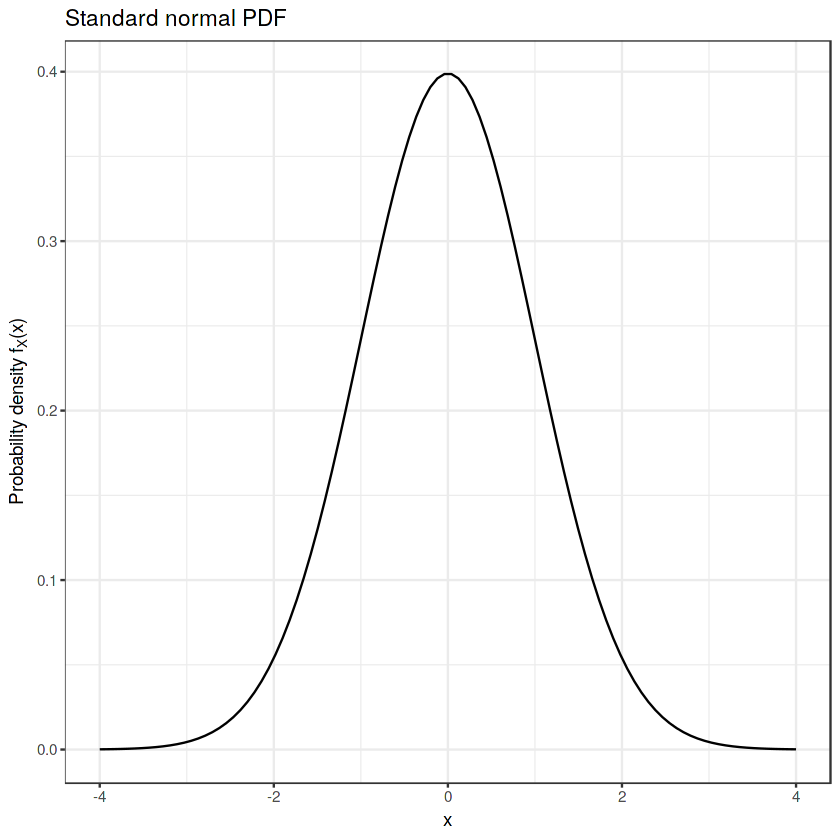

In [67]:
norm_pdf <- data %>%
    ggplot(aes(x = x, y = density)) +
    geom_line() +
    xlab("x") +
    ylab(TeX("Probability density $f_X(x)$")) +
    ggtitle("Standard normal PDF")

## I saved the plot as a variable for later use
## Now I just print it to plot it under the chunk
norm_pdf

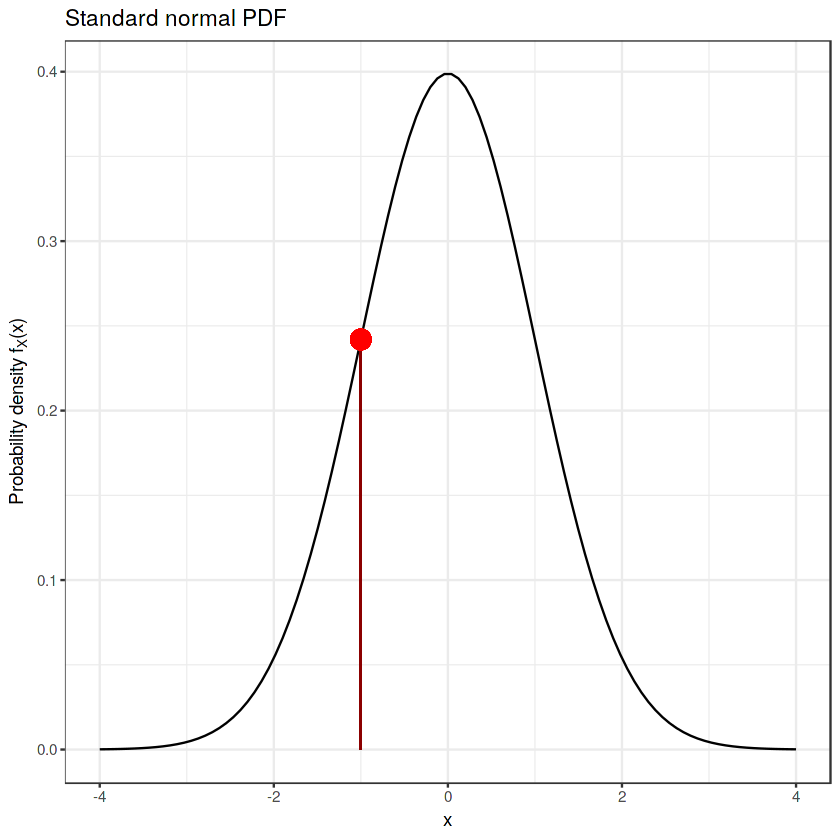

In [68]:
## A single point has probability 0
norm_pdf +
    geom_segment(x = -1, y = 0, xend = -1, yend = dnorm(-1), color = "darkred") +
    geom_point(x = -1, y = dnorm(-1), color = "red", size = 5)

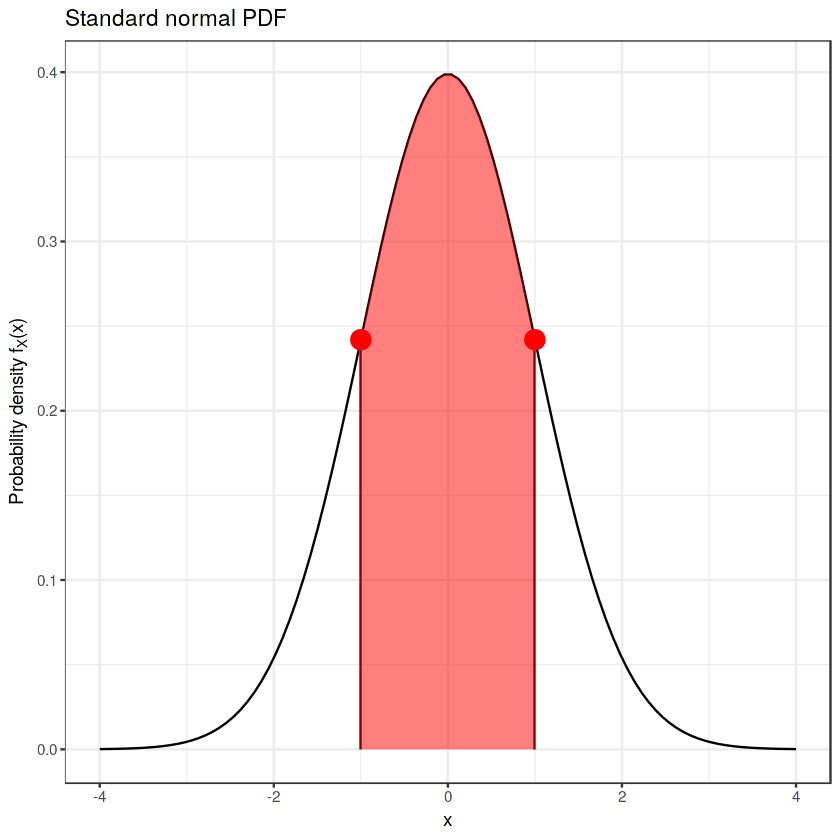

In [70]:
## A range of points has a well-defined probability
rng <- data.frame(x = c(-1, 1))


norm_pdf +
    geom_area(data = data.frame(x = seq(-1, 1, length.out = 100)), aes(x = x, y = dnorm(x)), fill = "red", alpha = .5) +
    geom_segment(data = rng, aes(x = x, y = 0, xend = x, yend = dnorm(x)), color = "darkred") +
    geom_point(data = rng, aes(x = x, y = dnorm(x)), color = "red", size = 5)

The area under the curve for the selected segment above is equal to the difference between two particular
points along the standard normal CDF $\Phi(x)$.

$$
\Phi(1) - \Phi(-1)
$$

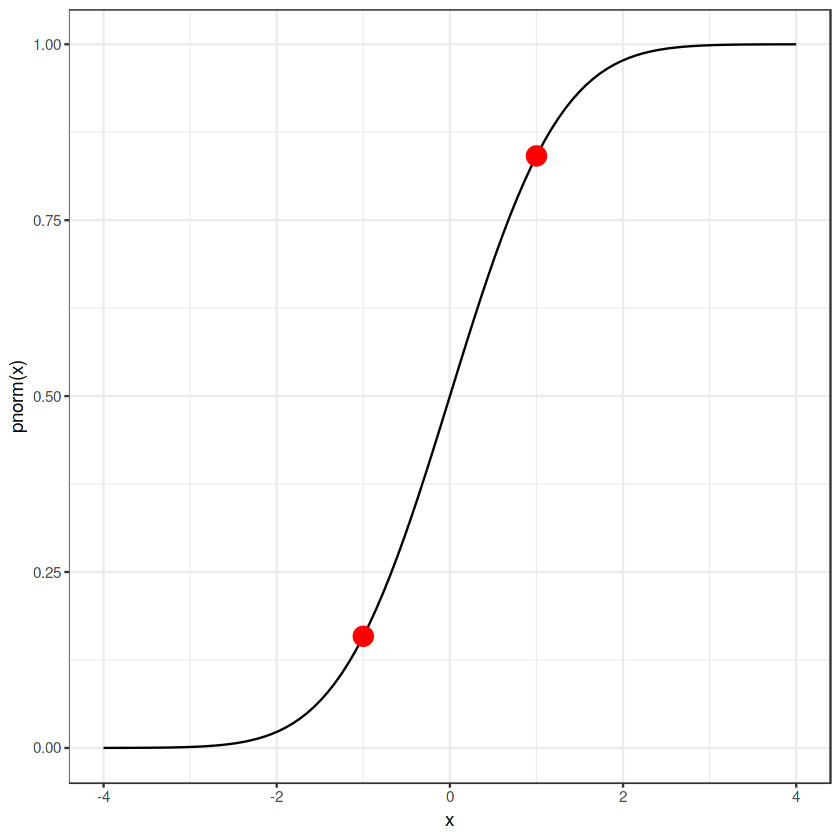

In [71]:
x <- seq(-4, 4, length.out = 100)

data <- data.frame(x = x)

data %>%
    ggplot(aes(x = x, y = pnorm(x))) +
    geom_line() +
    geom_point(data = data.frame(x = c(-1, 1)), aes(x = x, y = pnorm(x)), color = "red", size = 5)

## Quantile functions

In this section we just remind ourselves that quantile functions are inverses of CDFs.

For instance if $\Phi(x)$ is the standard normal CDF then $\Phi{-1}(p)$ is the standard normal quantile
function.

So we have that:

$$
\Phi^{-1}(\Phi(x)) = x
$$

In [74]:
## We can check this in R
qnorm(pnorm(3))

[1] 3

## Sampling from a distribution

As we already discussed we can sample easily from all probability distributions implemented in `R`.
For instance, to sample from a normal distribution we use `rnorm` function.

In [75]:
## Generate 100 normal variates with mean = 100 and standard deviation (sd) = 15
x <- rnorm(100, mean = 100, sd = 15)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



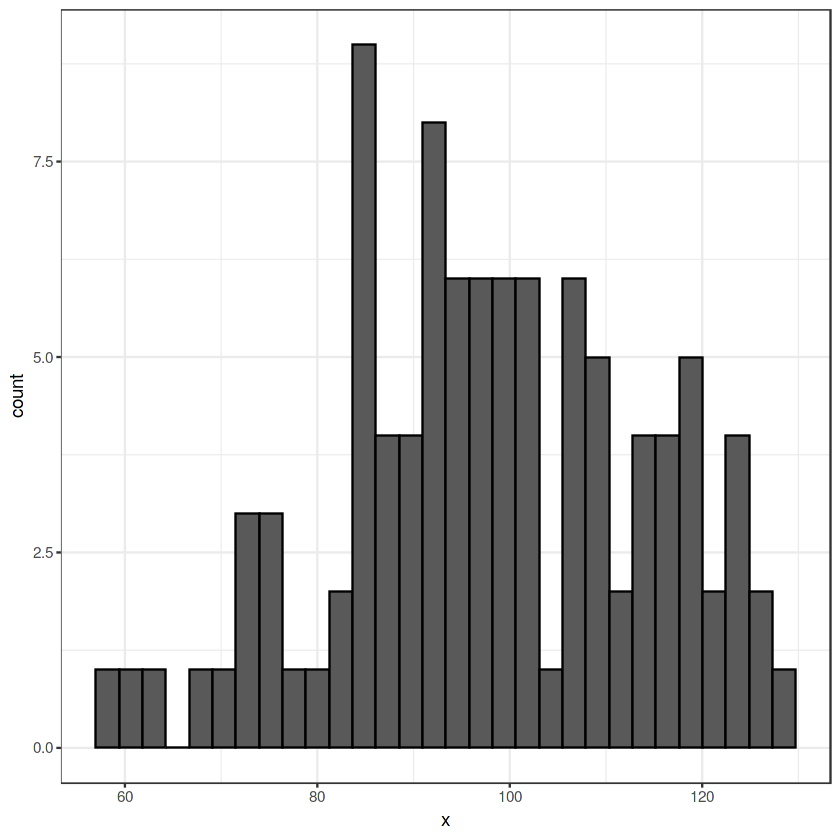

In [80]:
## Draw simple histogram of values
ggplot(data = data.frame(x = x), aes(x = x)) + 
    geom_histogram(color = "black")

We binned values into 30 bins (selected automatically). Maybe that is too high a resolution for a sample of only
$100$ data points. That is why we get a shape which is not very similar to the Bell curve.

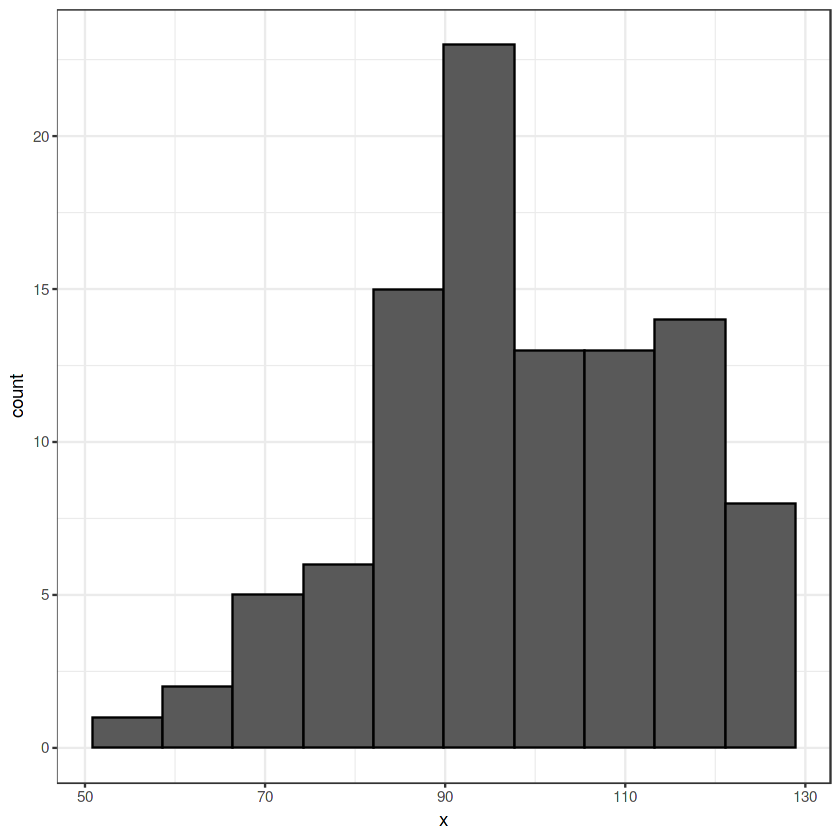

In [83]:
## Draw simple histogram of values with 10 bins
ggplot(data = data.frame(x = x), aes(x = x)) + 
    geom_histogram(bins = 10, color = "black")

Remember that sampling will generate different results every time. So:

In [85]:
x1 <- rnorm(100)
x2 <- rnorm(100)

all.equal(x1, x2)

[1] "Mean relative difference: 1.488236"

But we can force our pseudo-random generators to yield the same values by setting the random seed to
a particular value.

In [86]:
set.seed(101)
x1 <- rnorm(100)
set.seed(101)
x2 <- rnorm(100)

all.equal(x1, x2)

[1] TRUE

## Confidence intervals

Later on we will learn about functions and packages that will make it a breeze to run statistical tests
and compute confidence intervals. However, first we need to build proper understanding of the main concepts.

In the chunk below we will generate some random normal data and compute a two-sided $90\%$ confidence interval for the true  mean $\mu$ (of course we will know $\mu$ because we will define it for sampling, but for the sake of the exercise we will pretend otherwise).

In [87]:
x <- rnorm(250, mean = 100, sd = 15)

# Number of observations
n <- length(x)
# Sample mean
xbar <- mean(x)
# Sample variance
s2 <- var(x)
# Standard error of the mean (standard deviation of the sample mean distribution)
se <- sqrt(s2 / n)

The confidence interval we are trying to compute is two-sided and we want to have the confidence level of $90\%$.
Hence, we need to distribute $5\%$ of the error on each side. Thus, we need to determine what is the
$95\%$ quantile of the standard normal distribution $q^{0.95}$.

In [88]:
q95 <- qnorm(.95)

Now we can compute the confidence interval.

In [91]:
ci90 <- xbar + c(-1, 1) * se * q95
ci90

# Note the c(-1, 1) term. It is used to add and subtract `se * q95` at the same time
# to produce a range around `xbar`.

[1]  98.11807 101.07504

We see that our confidence interval contains the true mean $\mu = 100$. But is this always the case?
We know from the theory that a confidence interval should contain the true parameter with rate $1 - \alpha$,
that is, over multiple replications of a study $1 - \alpha$ is the fraction of experiments that yielded 
confidence interval overlapping with the true parameter value.

Now we will show this using simulations.

In [96]:
set.seed(303)

# True mean
mu <- 100
# Number of replications
R <- 1000
# Counter for counting intervals containing the true mean
counter <- 0
# Significance level (confidence is 1 - alpha)
alpha <- 0.10

# Loop and run the experiment multiple times
for (i in 1:R) {
    data <- rnorm(250, mean = mu, sd = 15)
    xbar <- mean(data)
    se   <- sqrt(var(data) / length(data))
    ci90 <- xbar + c(-1, 1) * se * qnorm(1 - alpha / 2) # alpha / 2 because this is a two-sided CI
    if (ci90[1] <= mu && ci90[2] >= mu) {
        counter <- counter + 1
    }
}

# Fraction of confidence intervals containing the mean
# (clearly it is very close to 90%)
counter / R

[1] 0.896

## Hypothesis testing

Now we will conduct a simple $z$ test for the difference between two mean. A $z$ test is a generic term
for a test that uses a test statistic which is distributed with the standard normal distribution.

The data we will use is normal that is why we know for sure that distributions of sample means in two
groups will be normal too and thus also the distribution of their difference will be normal.

We use the following hypotheses:

$$
H_0: \mu_1 = \mu_2
$$
$$
H_1: \mu_1 \neq \mu_2
$$

Moreover, we use $\alpha = 0.05$.

In [104]:
# Significance level
alpha <- 0.05

# Known true variances
sigma2_1 <- 2
sigma2_2 <- 3

x1 <- rnorm(100, mean = 10, sd = sigma2_1)
x2 <- rnorm(80, mean = 11, sd = sigma2_2)

n1 <- length(x1)
n2 <- length(x2)

xbar1 <- mean(x1)
xbar2 <- mean(x2)

diff  <- xbar1 - xbar2

# Standard error of the difference
se_diff <- sqrt(sigma2_1 / n1 + sigma2_2 / n2)

# Test statistic (under H_0 we have that z ~ Norm(0, 1))
z <- diff / se_diff
z

[1] -2.882666

In [105]:
# Rejection region boundaries based on alpha = 0.05
# We divide alpha / 2 because the test is two-sided
rejection_boundaries <- c(-1, 1) * qnorm(1 - alpha / 2)
rejection_boundaries

[1] -1.959964  1.959964

Clearly the test statistic does land in one of the rejection regions. So we can reject the null hypothesis.
We can also get a more finely-grained result by computing the corresponding $p$-value.

In [123]:
2 * pnorm(z)

[1] 0.003943256

Last but not least, we can also get a better, interval estimate of the effect by computing the confidence
interval for the difference between the sample means.

In [124]:
diff + c(-1, 1) * se_diff * qnorm(1 - alpha / 2)

[1] -1.1612218 -0.2212561

Now we can compare our results with an implementation of a simple $z$ test provided in `BSDA` package.

In [126]:
BSDA::z.test(x1, x2, sigma.x = sqrt(sigma2_1), sigma.y = sqrt(sigma2_2))


	Two-sample z-Test

data:  x1 and x2
z = -2.8827, p-value = 0.003943
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1612218 -0.2212561
sample estimates:
mean of x mean of y 
 9.923884 10.615123 


Clearly, all results are the same.